In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import PIL
from PIL import Image
import cv2 


img = cv2.imread(r'C:\Users\Asus\Documents\Python\test_im.jpeg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

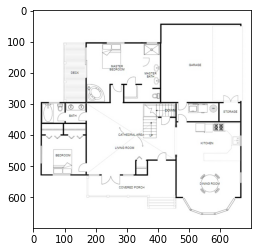

In [2]:
plt.imshow(img)

In [3]:
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

In [4]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 50  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments
line_image = np.copy(img) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)
#print(lines)

points = []
for line in lines:
    for x1, y1, x2, y2 in line:
        points.append(((x1 + 0.0, y1 + 0.0), (x2 + 0.0, y2 + 0.0)))
        cv2.line(line_image, (x1, y1), (x2, y2), (60, 100, 65), 5)

(700, 700, 3)


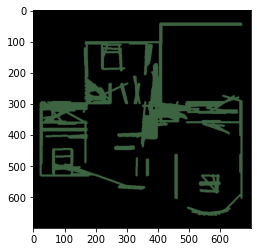

In [5]:
# Draw the lines on the  image
lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0)
print(lines_edges.shape)
cv2.imwrite('line_parking.png', lines_edges)
plt.imshow(line_image)

In [6]:
lines[0][0]

array([493, 295, 611, 295], dtype=int32)

In [7]:
len(lines)

267

In [8]:
def get_line(x1, y1, x2, y2):
    points = []
    issteep = abs(y2-y1) > abs(x2-x1)
    if issteep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2
    rev = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        rev = True
    deltax = x2 - x1
    deltay = abs(y2-y1)
    error = int(deltax / 2)
    y = y1
    ystep = None
    if y1 < y2:
        ystep = 1
    else:
        ystep = -1
    for x in range(x1, x2 + 1):
        if issteep:
            points.append((y, x))
        else:
            points.append((x, y))
        error -= deltay
        if error < 0:
            y += ystep
            error += deltax
    # Reverse the list if the coordinates were reversed
    if rev:
        points.reverse()
    return points

In [9]:
all_points = []
sum = 0
for i in range(267):
    points = get_line(lines[i][0][0], lines[i][0][1], lines[i][0][2], lines[i][0][3])
    all_points.extend(points)
    
    
    #if(i==0): print(len(points))
    #if(i==0): print(points)

print(len(all_points))  

22557


In [ ]:
#2D Gaussian function
def twoD_Gaussian(x, y, xo, yo, sigma_x, sigma_y):
    a = 1./(2*sigma_x**2) + 1./(2*sigma_y**2)              #Constants for the Guassian Term
    c = 1./(2*sigma_x**2) + 1./(2*sigma_y**2)
    
    gaus = np.exp(-(a*((x-xo)**2) + c*((y-yo)**2)))        #Gaussian decay term
    
    alpha = 0.01                                           #Decay constant for log loss term
    dist = 10*alpha*np.log10(((x-xo)**2) + ((y-yo)**2))    #Log loss term
    
    const = np.full(gaus.shape, 0)                         #Const term
    
    #print(const.shape)
    #print(dist.shape)
    
    net = gaus - dist + const 
    return net.ravel()

def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"

    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.8, N+4)
    return mycmap


#Use base cmap to create transparent
mycmap = transparent_cmap(plt.cm.Greens)


# Import image and get x and y extents
I = Image.open(r"C:\Users\Asus\Documents\Python\test_im.jpeg")
p = np.asarray(I).astype('float')
w, h = I.size

# Marking the "pixels" in the image  
y, x = np.mgrid[0:h, 0:w]
#print(x[0][0])
#print(y)

#Plot image and overlay colormap
#fig, ax = plt.subplots(1, 1)
#ax.imshow(I)


# 0.5*x.max() is the x-coordinate at which we are placing the wi-fi router
# 0.5*y.max() is the y-coordinate at which we are placing the wi-fi router 
# 0.6*x.max() is taken as the standard deviation in x direction about the center (To be taken as an input)
centre_x = 0.5*x.max()
#print(centre_x)
centre_y = 0.5*y.max()
sd_x = 0.6*x.max()
sd_y = 0.6*y.max()

Gauss = twoD_Gaussian(x, y, centre_x, centre_y, sd_x, sd_y)
Gauss = Gauss.reshape(x.shape[0], y.shape[1])
#print(Gauss.shape)

points1 = []
def attenua(Gauss):
    for i in x[0]:
        for j in y[0]:
            points1 = get_line(i, j, int(centre_x), int(centre_y))
            for point in points1:
                if(point in all_points):
                    Gauss[i][j] -= 0.25
    return Gauss
Gauss = attenua(Gauss)

In [ ]:
#Plot image and overlay colormap
fig, ax = plt.subplots(1, 1)
ax.imshow(I)
cb = ax.contourf(x, y, Gauss, 15, cmap=mycmap)
plt.colorbar(cb)
plt.show()